Author: François Mercier

Goal: Analyzing the predictions (understanding where is bad/good)

# Imports

Additional requirements for this notebook (not part of main requirements)
```
pip install --no-index matplotlib 
pip install --no-index scikit-learn
pip install --no-index seaborn
pip install fastprogress
````

Additional requirements to be part of main requirements (used by TAs utilities functions)

```
pip install opencv-python
pip install lz4
pip install --no-index tqdm
pip install --no-index h5netcdf
````

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path
import pandas as pd
import numpy as np
import json

from fastprogress import progress_bar

import h5netcdf
import cv2 as cv

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.__version__

'2.0.0'

In [6]:
import sys
sys.path.append("..") # Require to have the utilities packages in path
from utilities.utils import *

In [7]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

In [8]:
data_path = Path(r"../configs/admin")
list(data_path.glob("*"))

[PosixPath('../configs/admin/schema.json'),
 PosixPath('../configs/admin/hourly_random_train.json'),
 PosixPath('../configs/admin/hourly_daytime_shuffle_train.json'),
 PosixPath('../configs/admin/dummy_test_cfg.json'),
 PosixPath('../configs/admin/daily_random_01_test.json'),
 PosixPath('../configs/admin/hourly_daytime_01_test.json'),
 PosixPath('../configs/admin/daily_random_01_train.json'),
 PosixPath('../configs/admin/hourly_daytime_shuffle_validation.json'),
 PosixPath('../configs/admin/hourly_daytime_01_validation.json'),
 PosixPath('../configs/admin/daily_daytime_01_validation.json'),
 PosixPath('../configs/admin/daily_daytime_01_test.json'),
 PosixPath('../configs/admin/hourly_random_test.json'),
 PosixPath('../configs/admin/daily_daytime_01_train.json'),
 PosixPath('../configs/admin/daily_random_01_validation.json'),
 PosixPath('../configs/admin/hourly_random_validation.json'),
 PosixPath('../configs/admin/hourly_daytime_01_train.json'),
 PosixPath('../configs/admin/hourly_dayt

# Retrieve the hourly dataset

In [133]:
with open(data_path / "hourly_daytime_01_validation.json", 'r') as f:
    hourly_valid_dataset = json.load(f)

hourly_valid_datapoint = pd.Series(hourly_valid_dataset["target_datetimes"])
hourly_valid_datapoint = pd.Series(hourly_valid_datapoint.values, index=pd.to_datetime(hourly_valid_datapoint))
hourly_valid_datapoint.head()

2014-01-01 00:15:00    2014-01-01T00:15:00
2014-01-01 12:45:00    2014-01-01T12:45:00
2014-01-01 13:15:00    2014-01-01T13:15:00
2014-01-01 14:45:00    2014-01-01T14:45:00
2014-01-01 15:45:00    2014-01-01T15:45:00
dtype: object

In [134]:
with open(data_path / "hourly_daytime_01_train.json", 'r') as f:
    hourly_train_dataset = json.load(f)
    
hourly_train_datapoint = pd.Series(hourly_train_dataset["target_datetimes"])
hourly_train_datapoint = pd.Series(hourly_train_datapoint.values, index=pd.to_datetime(hourly_train_datapoint))
hourly_train_datapoint.head()

2010-04-14 19:45:00    2010-04-14T19:45:00
2010-04-14 20:30:00    2010-04-14T20:30:00
2010-04-14 21:30:00    2010-04-14T21:30:00
2010-04-14 22:30:00    2010-04-14T22:30:00
2010-04-14 23:00:00    2010-04-14T23:00:00
dtype: object

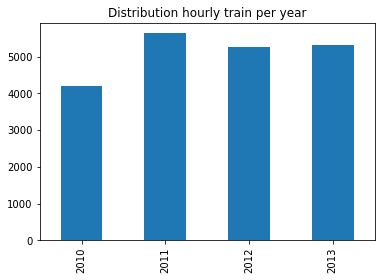

In [135]:
hourly_train_datapoint.groupby([hourly_train_datapoint.index.year]).size().plot.bar(title="Distribution hourly train per year")

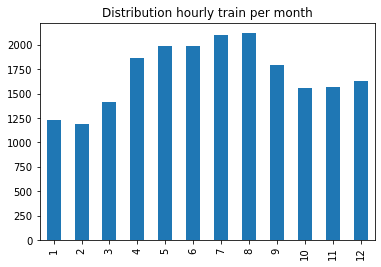

In [136]:
hourly_train_datapoint.groupby([hourly_train_datapoint.index.month]).size().plot.bar(title="Distribution hourly train per month")

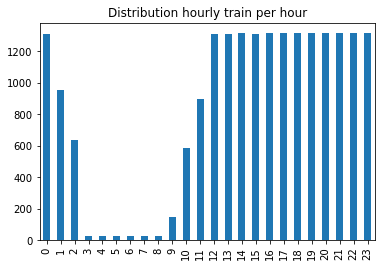

In [137]:
hourly_train_datapoint.groupby([hourly_train_datapoint.index.hour]).size().plot.bar(title="Distribution hourly train per hour")

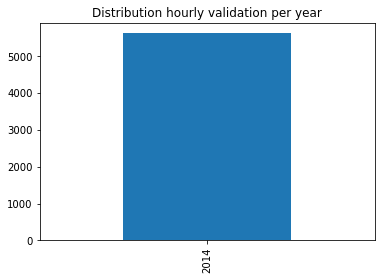

In [89]:
hourly_valid_datapoint.groupby([hourly_valid_datapoint.index.year]).size().plot.bar(title="Distribution hourly validation per year")

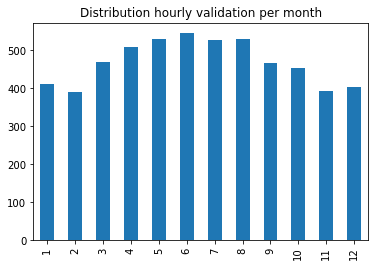

In [90]:
hourly_valid_datapoint.groupby([hourly_valid_datapoint.index.month]).size().plot.bar(title="Distribution hourly validation per month")

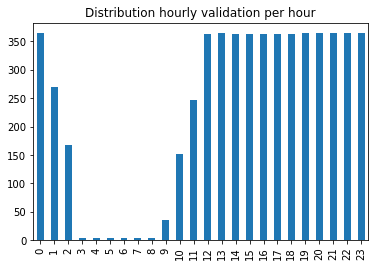

In [91]:
hourly_valid_datapoint.groupby([hourly_valid_datapoint.index.hour]).size().plot.bar(title="Distribution hourly validation per hour")

# Retrieve the daily dataset

In [138]:
with open(data_path / "daily_daytime_01_train.json", 'r') as f:
    daily_train_dataset = json.load(f)
daily_train_datapoint = pd.Series(daily_train_dataset["target_datetimes"])
daily_train_datapoint = pd.Series(daily_train_datapoint.values, index=pd.to_datetime(daily_train_datapoint))
daily_train_datapoint.head()

2010-04-14 21:45:00    2010-04-14T21:45:00
2010-04-15 23:30:00    2010-04-15T23:30:00
2010-04-16 10:45:00    2010-04-16T10:45:00
2010-04-17 00:15:00    2010-04-17T00:15:00
2010-04-18 01:15:00    2010-04-18T01:15:00
dtype: object

In [139]:
with open(data_path / "daily_daytime_01_validation.json", 'r') as f:
    daily_valid_dataset = json.load(f)
daily_valid_datapoint = pd.Series(daily_valid_dataset["target_datetimes"])
daily_valid_datapoint = pd.Series(daily_valid_datapoint.values, index=pd.to_datetime(daily_valid_datapoint))
daily_valid_datapoint.head()

2014-01-01 14:30:00    2014-01-01T14:30:00
2014-01-02 14:00:00    2014-01-02T14:00:00
2014-01-03 15:45:00    2014-01-03T15:45:00
2014-01-04 12:45:00    2014-01-04T12:45:00
2014-01-05 17:30:00    2014-01-05T17:30:00
dtype: object

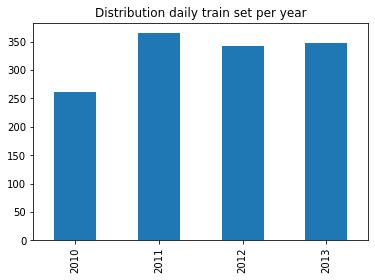

In [140]:
daily_train_datapoint.groupby([daily_train_datapoint.index.year]).size().plot.bar(title="Distribution daily train set per year")

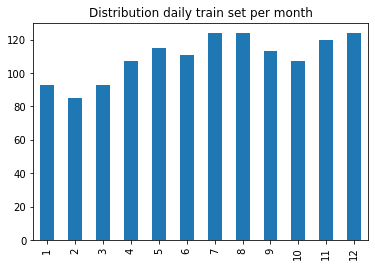

In [141]:
daily_train_datapoint.groupby([daily_train_datapoint.index.month]).size().plot.bar(title="Distribution daily train set per month")

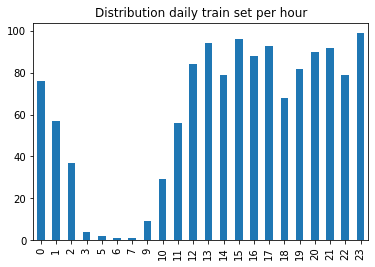

In [142]:
daily_train_datapoint.groupby([daily_train_datapoint.index.hour]).size().plot.bar(title="Distribution daily train set per hour")

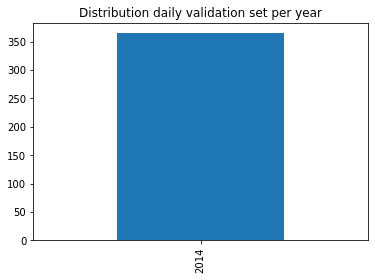

In [86]:
daily_valid_datapoint.groupby([daily_valid_datapoint.index.year]).size().plot.bar(title="Distribution daily validation set per year")

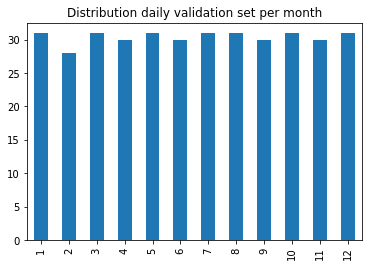

In [87]:
daily_valid_datapoint.groupby([daily_valid_datapoint.index.month]).size().plot.bar(title="Distribution daily validation set per month")

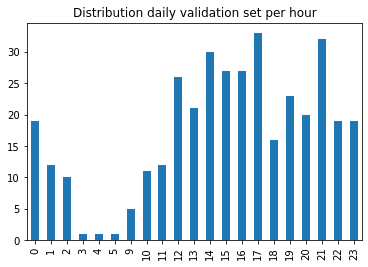

In [88]:
daily_valid_datapoint.groupby([daily_valid_datapoint.index.hour]).size().plot.bar(title="Distribution daily validation set per hour")

# Compare GHI

In [94]:
df = pd.read_pickle(hourly__valid_dataset["dataframe_path"])

In [144]:
hourly_valid_df = df[df.index.isin(hourly_valid_datapoint)]
daily_valid_df = df[df.index.isin(daily_valid_datapoint)]

hourly_train_df = df[df.index.isin(hourly_train_datapoint)]
daily_train_df = df[df.index.isin(daily_train_datapoint)]

In [150]:
#stations = df.columns[df.columns.str.contains('^.{3}_GHI$')]
stations = df.columns[df.columns.str.contains('_GHI$')]

In [151]:
hourly_train_df[stations].describe(percentiles=np.concatenate([np.arange(0, .75, 0.25), [.9, .95, .99]]))

,BND_CLEARSKY_GHI,BND_GHI,TBL_CLEARSKY_GHI,TBL_GHI,DRA_CLEARSKY_GHI,DRA_GHI,FPK_CLEARSKY_GHI,FPK_GHI,GWN_CLEARSKY_GHI,GWN_GHI,PSU_CLEARSKY_GHI,PSU_GHI,SXF_CLEARSKY_GHI,SXF_GHI
count,20403.000000,20382.000000,20391.000000,20327.000000,20361.000000,20357.000000,20388.000000,20363.000000,19894.000000,19869.000000,20359.000000,20315.000000,20297.000000,20278.000000
mean,347.034020,268.735138,386.626852,304.736381,398.730731,371.558546,321.079720,257.857979,374.409256,300.675294,349.816643,242.136898,333.374086,265.994056
std,309.495548,293.292701,344.932730,314.274424,347.642959,348.045026,300.952745,276.255535,325.077173,314.057728,312.353441,275.636134,304.466399,284.962738
min,0.000000,-7.006667,0.000000,-7.806667,0.000000,-10.613333,0.000000,-9.873333,0.000000,-13.100000,0.000000,-8.166667,0.000000,-29.028571
0%,0.000000,-7.006667,0.000000,-7.806667,0.000000,-10.613333,0.000000,-9.873333,0.000000,-13.100000,0.000000,-8.166667,0.000000,-29.028571
25%,4.772642,4.736667,8.028091,9.460000,11.549958,16.046667,7.024730,8.403333,7.277665,7.180000,6.903648,5.950000,5.156979,6.635000
50%,317.909148,157.910000,350.017338,203.260000,376.015488,304.580000,263.456801,160.540000,358.183136,185.513333,324.418392,131.986667,296.973289,165.373333
90%,815.513432,751.478000,905.964401,807.660000,918.366080,910.138667,790.152210,707.916000,854.075410,804.776000,825.555386,698.845333,802.268483,730.396000
95%,877.589797,865.836333,982.484820,929.572667,982.718620,1001.181333,865.545888,822.446000,911.186076,907.650667,883.899215,832.200667,869.425004,846.659333
99%,919.131099,984.105267,1032.519502,1044.071333,1031.236854,1073.580800,922.134289,936.418400,954.864131,1015.714400,932.130520,966.545067,919.426318,961.946067


In [152]:
hourly_valid_df[stations].describe(percentiles=np.concatenate([np.arange(0, .75, 0.25), [.9, .95, .99]]))

,BND_CLEARSKY_GHI,BND_GHI,TBL_CLEARSKY_GHI,TBL_GHI,DRA_CLEARSKY_GHI,DRA_GHI,FPK_CLEARSKY_GHI,FPK_GHI,GWN_CLEARSKY_GHI,GWN_GHI,PSU_CLEARSKY_GHI,PSU_GHI,SXF_CLEARSKY_GHI,SXF_GHI
count,5613.000000,5609.000000,5623.000000,5591.000000,5621.000000,5620.000000,5608.000000,5602.000000,5551.000000,5067.000000,5610.000000,5599.000000,5616.000000,5553.000000
mean,345.241059,260.089741,385.410209,293.483783,397.402973,369.725044,318.574077,244.522864,372.357629,273.788977,348.516978,239.642205,330.730592,252.786312
std,307.185203,286.354694,343.415106,305.916681,346.167913,346.139831,298.795571,267.680455,323.583681,299.310420,309.564297,273.694441,302.439408,272.926874
min,0.000000,-5.286667,0.000000,-4.846667,0.000000,-6.893333,0.000000,-5.333333,0.000000,-6.160000,0.000000,-4.613333,0.000000,-25.066667
0%,0.000000,-5.286667,0.000000,-4.846667,0.000000,-6.893333,0.000000,-5.333333,0.000000,-6.160000,0.000000,-4.613333,0.000000,-25.066667
25%,5.686800,6.686667,11.236186,11.963333,11.278746,18.646667,7.652795,8.625000,7.889630,3.710000,7.212632,7.190000,5.583234,6.706667
50%,320.705424,147.086667,346.235336,194.133333,374.272012,298.130000,261.985754,149.730000,358.913676,156.040000,328.024837,129.333333,292.352028,153.513333
90%,809.418485,730.670667,898.651029,784.493333,911.177562,905.518667,782.226651,679.939333,848.847106,750.653333,817.622655,693.278667,796.916828,683.206667
95%,873.981384,844.825333,980.557476,908.896667,976.456835,992.359667,864.501022,804.418333,906.244868,870.126000,880.341269,821.914667,866.420217,813.273333
99%,919.604324,961.396267,1032.831924,1044.500667,1030.399339,1072.599267,922.115743,939.379667,952.324231,996.378667,932.677610,973.418533,919.865638,954.860267


In [153]:
daily_train_df[stations].describe(percentiles=np.concatenate([np.arange(0, .75, 0.25), [.9, .95, .99]]))

,BND_CLEARSKY_GHI,BND_GHI,TBL_CLEARSKY_GHI,TBL_GHI,DRA_CLEARSKY_GHI,DRA_GHI,FPK_CLEARSKY_GHI,FPK_GHI,GWN_CLEARSKY_GHI,GWN_GHI,PSU_CLEARSKY_GHI,PSU_GHI,SXF_CLEARSKY_GHI,SXF_GHI
count,1315.000000,1314.000000,1314.000000,1310.000000,1312.000000,1312.000000,1315.000000,1314.000000,1290.000000,1287.000000,1312.000000,1308.000000,1310.000000,1310.000000
mean,339.622385,262.697681,378.287033,306.139111,390.897248,364.882851,311.490150,250.779802,367.207262,292.911593,341.973218,242.217548,324.942464,254.248127
std,309.396863,291.372064,344.302505,318.601569,346.485079,345.217225,301.489523,274.945349,324.203916,314.088151,313.004154,279.196817,305.014562,281.519766
min,0.000000,-6.666667,0.000000,-6.333333,0.000000,-10.593333,0.000000,-6.320000,0.000000,-8.793333,0.000000,-5.593333,0.000000,-24.993333
0%,0.000000,-6.666667,0.000000,-6.333333,0.000000,-10.593333,0.000000,-6.320000,0.000000,-8.793333,0.000000,-5.593333,0.000000,-24.993333
25%,2.883860,3.743333,2.210302,4.691667,11.303905,12.981667,0.642633,1.503333,6.416540,7.543333,5.374019,4.940000,1.250145,3.521667
50%,308.468506,147.826667,340.436788,204.593333,359.904698,304.203333,247.170742,153.910000,338.296604,169.233333,298.567073,128.660000,277.200100,147.450000
90%,810.328443,762.916000,901.393044,809.442667,910.011809,890.470000,786.506843,701.262000,842.341494,810.648000,820.297043,694.139333,796.323696,724.598667
95%,876.046567,859.122000,969.774794,933.292667,974.192960,985.426000,853.424825,814.928000,906.915184,902.444667,885.256201,847.592000,860.301479,834.304667
99%,916.394416,967.063067,1027.652220,1037.227267,1022.514528,1072.899600,920.354385,927.619467,956.241471,1017.675200,930.420139,978.650400,914.827105,950.738800


In [154]:
daily_valid_df[stations].describe(percentiles=np.concatenate([np.arange(0, .75, 0.25), [.9, .95, .99]]))

,BND_CLEARSKY_GHI,BND_GHI,TBL_CLEARSKY_GHI,TBL_GHI,DRA_CLEARSKY_GHI,DRA_GHI,FPK_CLEARSKY_GHI,FPK_GHI,GWN_CLEARSKY_GHI,GWN_GHI,PSU_CLEARSKY_GHI,PSU_GHI,SXF_CLEARSKY_GHI,SXF_GHI
count,364.000000,363.000000,365.000000,362.000000,365.000000,365.000000,363.000000,363.000000,361.000000,331.000000,364.000000,362.000000,364.000000,360.000000
mean,347.237352,245.857943,379.611243,294.589650,385.699622,355.669502,307.592424,239.884848,379.851008,293.446651,350.426776,240.638398,326.506667,252.677333
std,303.262589,277.754598,336.495369,303.127235,340.001383,336.640192,293.736255,267.567546,318.653796,309.388639,307.614512,272.783042,296.715918,271.825752
min,0.000000,-5.393333,0.000000,-4.780000,0.000000,-6.800000,0.000000,-4.700000,0.000000,-5.586667,0.000000,-3.313333,0.000000,-19.933333
0%,0.000000,-5.393333,0.000000,-4.780000,0.000000,-6.800000,0.000000,-4.700000,0.000000,-5.586667,0.000000,-3.313333,0.000000,-19.933333
25%,10.415952,6.343333,0.297344,4.266667,11.544694,16.493333,0.612906,2.750000,17.669310,5.366667,14.433998,7.466667,1.893033,1.048333
50%,323.665126,136.213333,362.948995,226.743333,372.747291,300.986667,259.247966,140.533333,386.137684,169.053333,331.208011,125.933333,308.839000,147.676667
90%,788.576458,711.173333,891.548580,772.563333,905.121663,896.448000,759.162136,679.325333,835.357047,760.126667,791.368107,710.480000,784.536433,677.954000
95%,857.852005,796.138667,971.248774,937.024667,973.173962,986.349333,863.056160,799.163333,897.032214,885.490000,877.030227,813.385000,860.419738,812.015333
99%,914.476584,941.842667,1021.077380,1026.194733,1022.883245,1055.833867,908.694732,924.724267,960.479206,1007.112000,921.771467,930.947000,916.601985,912.238533


# Conclusion 

- The two dataset don't have the same distribution of daypoint, especially per hour
- Similar distribution over stations
- However, TBL seems to be particularly off
- The hourly dataset seem to be more consitent between the train and validation set
- It doesn't seem that we have got outliers based on the clearsky model. (we should remove the clip of output)